In [ ]:
from google.colab import files
uploaded = files.upload()

Saving covid_19_clean_complete.csv to covid_19_clean_complete.csv


**Import libraries for analysis,visualizing and computing the dataset.**

In [1]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Data Aquisition and Data Pre-processing.** 

In Data Aquisition where we aquire the data from relevant source, in this project we have taken data from John Hopkin, where in Data Pre-processing we removing Irrelevant feature and select relevant feature as from the dataset we extracted confirmed cases for Top 10 countries as relevant feature.

In [2]:
dataframe=pd.read_csv('/content/covid_19_clean_complete.csv',parse_dates=['Date'])# read the csv file and upload in an variable.

In [3]:
dataframe ['Province/State']=dataframe['Province/State'].fillna('')#fill the Na value with space.
dataframe

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,,Afghanistan,33.000000,65.000000,2020-01-22,0,0,0
1,,Albania,41.153300,20.168300,2020-01-22,0,0,0
2,,Algeria,28.033900,1.659600,2020-01-22,0,0,0
3,,Andorra,42.506300,1.521800,2020-01-22,0,0,0
4,,Angola,-11.202700,17.873900,2020-01-22,0,0,0
...,...,...,...,...,...,...,...,...
32060,,Sao Tome and Principe,0.186360,6.613081,2020-05-21,251,8,4
32061,,Yemen,15.552727,48.516388,2020-05-21,197,33,0
32062,,Comoros,-11.645500,43.333300,2020-05-21,34,1,8
32063,,Tajikistan,38.861034,71.276093,2020-05-21,2350,44,0


In [4]:
dataframe.rename(columns={'Country/Region':'Country','Province/State':'State'},inplace=True)# rename the column (Country/Region as Country and Province/State as State).

In [5]:
rvd = dataframe.fillna('').groupby('Country')[['Confirmed','Deaths','Recovered']].max()# extract the values of Confirmed , Deaths ,Recovered with respect to    
rvd=rvd.sort_values(by=['Confirmed','Deaths'],ascending=False)# sort out the values with respect to Confirmed and Death.
rvd=rvd.head(10)# show just top 10 values in output.
rvd

,Confirmed,Deaths,Recovered
Country,,,
US,1577147,94702,298418
Russia,317554,3099,92681
Brazil,310087,20047,125960
United Kingdom,250908,36042,508
Spain,233037,27940,150376
Italy,228006,32486,134560
France,179306,28193,62216
Germany,179021,8203,158087
Turkey,153548,4249,114990


**Data** **Transformation**

In Data Transformation we analysis and check the stationarity of confirmed cases data from our given dataframe by method of visualizing means Rolling Statistic and by statistic method using Augmented Dickey-Fuller test.


In [6]:
sns.set(palette = 'Set1',style='darkgrid')
#Function for making a time serie on a designated country and plotting the rolled mean and standard 
def roll(country,case='Recovered'):
    CDR=dataframe.loc[(dataframe['Country']==country)]  
    CDR=CDR[['Date',case]]
    CDR=CDR.set_index('Date')
    CDR.astype('int64')
    a=len(CDR.loc[(CDR['Recovered']>=10)])
    CDR=CDR[-a:]
    return (CDR.rolling(window=4,center=False).mean().dropna())


def rollPlot(country, case='Recovered'):
    CDR=dataframe.loc[(dataframe['Country']==country)]  
    CDR=CDR[['Date',case]]
    CDR=CDR.set_index('Date')
    CDR.astype('int64')
    a=len(CDR.loc[(CDR['Recovered']>=10)])
    CDR=CDR[-a:]
    plt.figure(figsize=(16,6))
    plt.plot(CDR.rolling(window=7,center=False).mean().dropna(),label='Rolling Mean')
    plt.plot(CDR[case], label='Recovered')
    plt.plot(CDR.rolling(window=7,center=False).std(),label='Rolling std')
    #plt.plot('Recovered', label='First Line')
    plt.legend()
    plt.title('Cases distribution in %s with rolling mean and standard' %country)
    plt.xticks([])

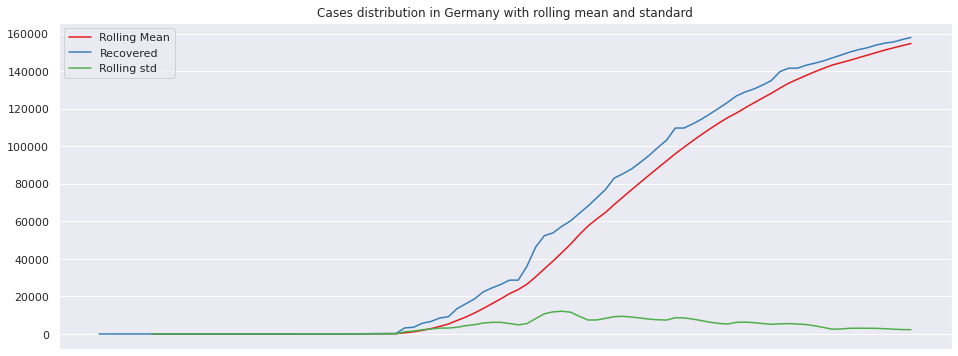

In [7]:
Gtest=roll('Germany')
rollPlot('Germany')

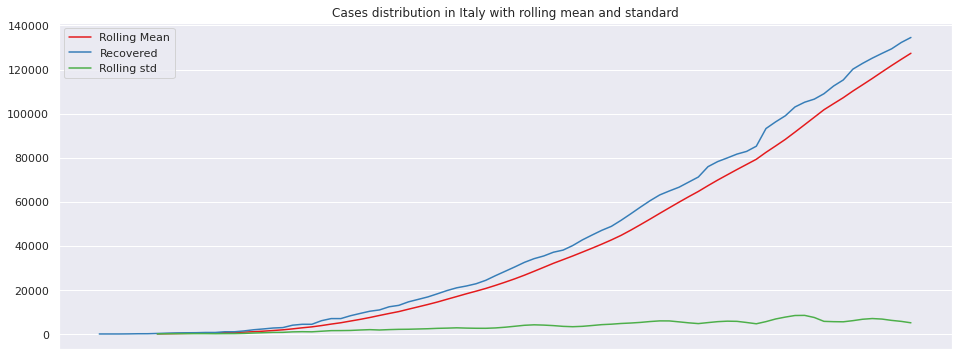

In [8]:
Itest=roll('Italy')
rollPlot('Italy')

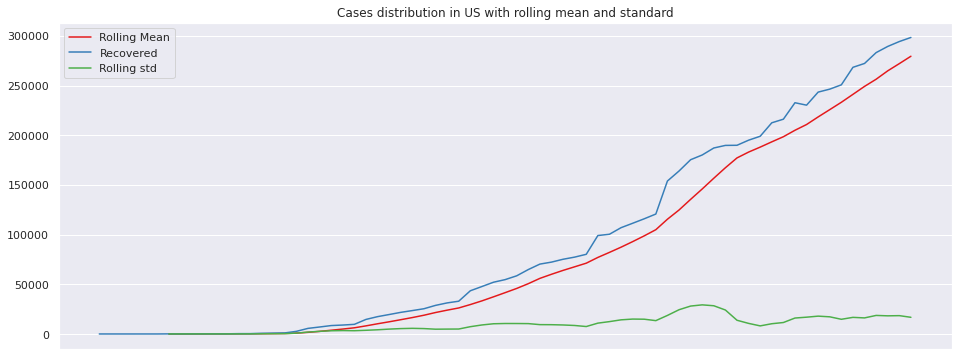

In [9]:
UStest=roll('US')
rollPlot('US')

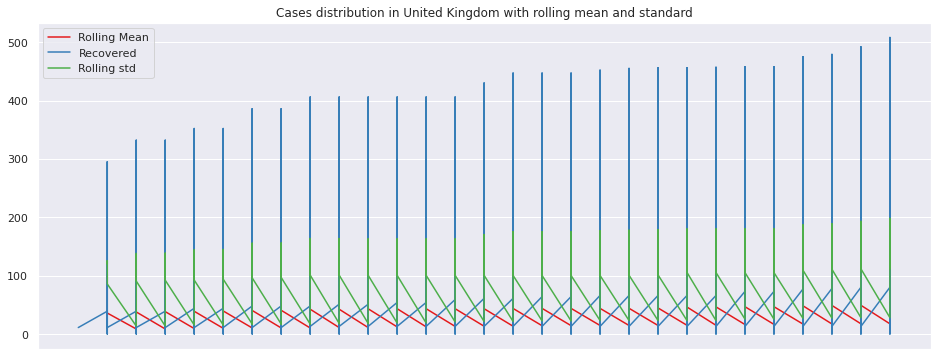

In [10]:
Uktest=roll('United Kingdom')
rollPlot('United Kingdom')

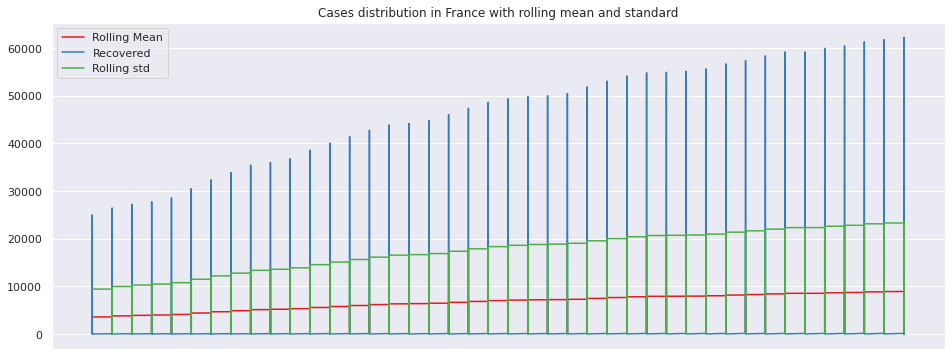

In [11]:
Ftest=roll('France')
rollPlot('France')

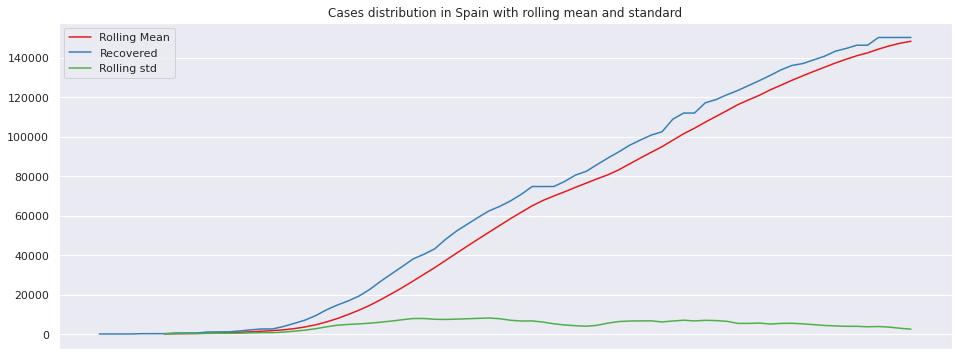

In [12]:
Sptest=roll('Spain')
rollPlot('Spain')

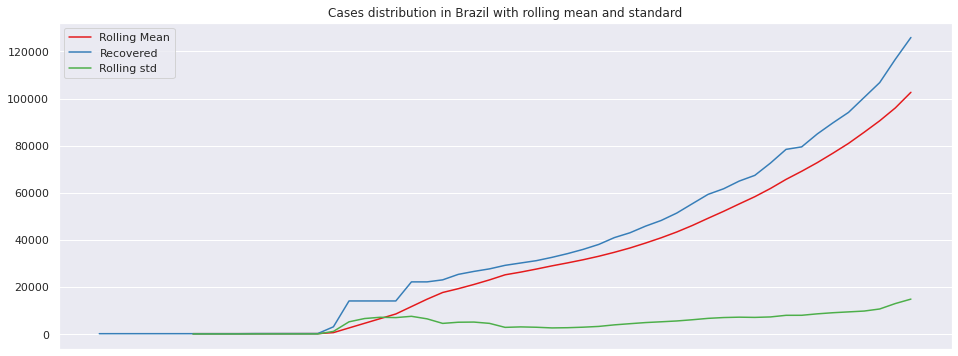

In [13]:
Bztest=roll('Brazil')
rollPlot('Brazil')

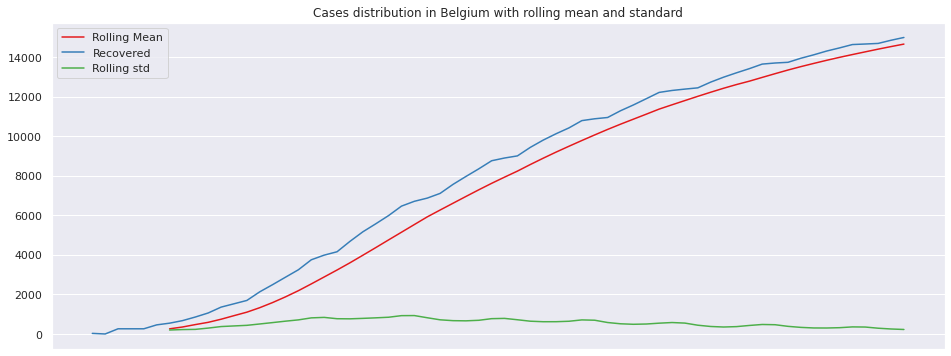

In [14]:
Bltest=roll('Belgium')
rollPlot('Belgium')

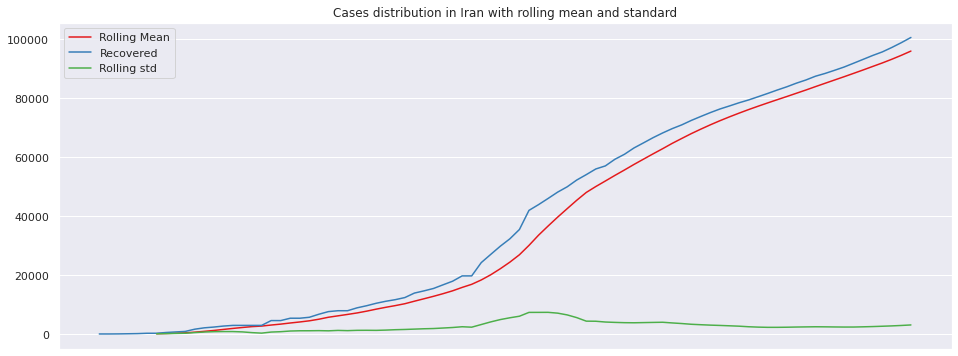

In [15]:
Irtest=roll('Iran')
rollPlot('Iran')

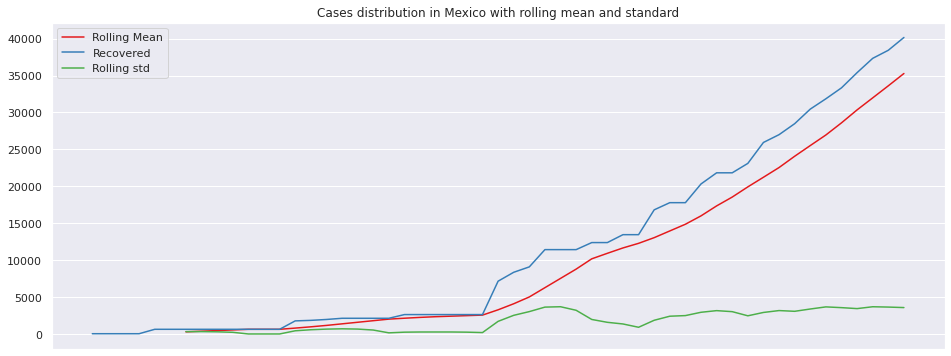

In [16]:
Mxtest=roll('Mexico')
rollPlot('Mexico')

**Modeling** 

Modeling of Time series data different models are used namely AR,MA,Sarima, Arima ,here we have use Arima model which consist of three component (p,q,d),before this the dataframe has been splited into train and test data, then for finding the best parameter of (p d q) we use grid search method. 

In [17]:
from statsmodels.tools.eval_measures import rmse, meanabs# import root mean square error and mean absolute  percentage error.
from sklearn.metrics import mean_squared_error,mean_absolute_error

**Recovered Cases of Germany**

Predicted values : [150767.12711794 152053.40208614 153432.2137884  154816.46529638
 156273.89187432 157826.71146623]
                             ARIMA Model Results                              
Dep. Variable:           D2.Recovered   No. Observations:                   83
Model:                 ARIMA(5, 2, 2)   Log Likelihood                -606.251
Method:                       css-mle   S.D. of innovations            349.943
Date:                Sun, 27 Sep 2020   AIC                           1230.502
Time:                        20:43:31   BIC                           1252.272
Sample:                    02-23-2020   HQIC                          1239.248
                         - 05-15-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 17.0042     36.568      0.465      0.643     -54.668  

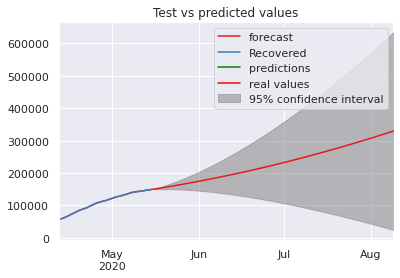

In [18]:

#Mean absolute percentage error
def mape(x1, x_pred): 
    x1, x_pred = np.array(x1), np.array(x_pred)
    return np.mean(np.abs((x1 - x_pred) / x1)) * 100

def split(CDR):
    #splitting 85%/15% because of little amount of data
    size = int(len(CDR) * 0.94)
    train= CDR[:size]
    test = CDR[size:]
    return(train,test)


#Arima modeling for CDR
def arima(CDR,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(CDR, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(CDR, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(CDR) * 0.6), end=int(len(CDR) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    #f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(Gtest)
prediction=arima(train,test)

***Recovered Cases of Italy. ***

Predicted values : [126659.10429666 129555.16036082 132813.25481494]
                             ARIMA Model Results                              
Dep. Variable:           D2.Recovered   No. Observations:                   77
Model:                 ARIMA(4, 2, 4)   Log Likelihood                -519.482
Method:                       css-mle   S.D. of innovations            189.900
Date:                Sun, 27 Sep 2020   AIC                           1058.963
Time:                        20:43:55   BIC                           1082.401
Sample:                    03-03-2020   HQIC                          1068.338
                         - 05-18-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 45.6827      1.929     23.679      0.000      41.901      49.464
ar.L1.D2.Recovered     0.3523      0.1

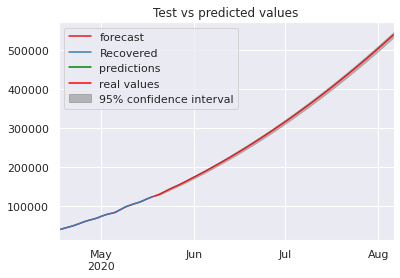

In [19]:

#Mean absolute percentage error
def mape(x1, x_pred): 
    x1, x_pred = np.array(x1), np.array(x_pred)
    return np.mean(np.abs((x1 - x_pred) / x1)) * 100

def split(CDR):
    #splitting 85%/15% because of little amount of data
    size = int(len(CDR) * 0.97)
    train= CDR[:size]
    test = CDR[size:]
    return(train,test)


#Arima modeling for CDR
def arima(CDR,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(CDR, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(CDR, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(CDR) * 0.6), end=int(len(CDR) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    #f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(Itest)
prediction=arima(train,test)

**Recovered Cases For US**

Predicted values : [292837.2572139]
                             ARIMA Model Results                              
Dep. Variable:           D2.Recovered   No. Observations:                   65
Model:                 ARIMA(1, 2, 5)   Log Likelihood                -559.129
Method:                       css-mle   S.D. of innovations           1208.560
Date:                Sun, 27 Sep 2020   AIC                           1134.259
Time:                        20:44:22   BIC                           1151.654
Sample:                    03-17-2020   HQIC                          1141.122
                         - 05-20-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                147.4898     26.432      5.580      0.000      95.684     199.296
ar.L1.D2.Recovered    -0.6623      0.285     -2.322      0.024      -1.

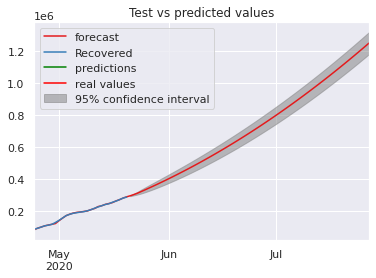

In [20]:

#Mean absolute percentage error
def mape(x1, x_pred): 
    x1, x_pred = np.array(x1), np.array(x_pred)
    return np.mean(np.abs((x1 - x_pred) / x1)) * 100

def split(CDR):
    #splitting 85%/15% because of little amount of data
    size = int(len(CDR) * 0.99)
    train= CDR[:size]
    test = CDR[size:]
    return(train,test)


#Arima modeling for CDR
def arima(CDR,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(CDR, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(CDR, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(CDR) * 0.6), end=int(len(CDR) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    #f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(UStest)
prediction=arima(train,test)

**Recovered Cases for Uk**

In [21]:
#Mean absolute percentage error
def mape(x1, x_pred): 
    x1, x_pred = np.array(x1), np.array(x_pred)
    return np.mean(np.abs((x1 - x_pred) / x1)) * 100

def split(CDR):
    #splitting 85%/15% because of little amount of data
    size = int(len(CDR) * 0.92)
    train= CDR[:size]
    test = CDR[size:]
    return(train,test)


#Arima modeling for CDR
def arima(CDR,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(CDR, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(CDR, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(CDR) * 0.6), end=int(len(CDR) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    #f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(Uktest)
prediction=arima(train,test)

Predicted values : [-32.67204857 -33.65755255 -25.7467706    8.70308574  93.51450044
 149.29447412 202.93103101 209.99606843 179.57938137 121.34548848
  48.87098212  -8.83042418 -38.06979967 -27.13639415  19.49539428
  86.64305478 153.54719595 198.31204002 207.27490596 177.51516455
 118.69870866  49.67224996  -7.68121965 -35.13042692 -24.13141038]
                              ARMA Model Results                              
Dep. Variable:              Recovered   No. Observations:                  281
Model:                     ARMA(5, 5)   Log Likelihood               -1216.394
Method:                       css-mle   S.D. of innovations             17.495
Date:                Sun, 27 Sep 2020   AIC                           2456.787
Time:                        20:45:41   BIC                           2500.447
Sample:                             0   HQIC                          2474.297
                                                                              
                  

ValueError: ignored

ValueError: ignored

<Figure size 432x288 with 1 Axes>

**Recovered Cases France.**

In [22]:

#Mean absolute percentage error
def mape(x1, x_pred): 
    x1, x_pred = np.array(x1), np.array(x_pred)
    return np.mean(np.abs((x1 - x_pred) / x1)) * 100

def split(CDR):
    #splitting 85%/15% because of little amount of data
    size = int(len(CDR) * 0.94)
    train= CDR[:size]
    test = CDR[size:]
    return(train,test)


#Arima modeling for CDR
def arima(CDR,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(CDR, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(CDR, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(CDR) * 0.6), end=int(len(CDR) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    #f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(Ftest)
prediction=arima(train,test)

Predicted values : [-3994.95247023  4133.30132981  4686.14701903  6793.38860886
 14055.40600656  9154.13185975  9093.95721969  9083.75063789
   840.05368499  3058.76000193  2592.93034233  -105.52843628
  7313.39076732  6756.48176268  7089.46389669 12138.85096546
  6663.81838482  6528.73846817  7238.55936108   960.20371271
  4282.26479259  4691.46548054  2414.9714115   8684.87098501
  7198.41536329  6494.19102775 10363.14902006  5143.46322584]
                             ARIMA Model Results                              
Dep. Variable:            D.Recovered   No. Observations:                  426
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -3902.088
Method:                       css-mle   S.D. of innovations           2230.481
Date:                Sun, 27 Sep 2020   AIC                           7824.176
Time:                        20:46:41   BIC                           7864.720
Sample:                             1   HQIC                          7840.191


ValueError: ignored

ValueError: ignored

<Figure size 432x288 with 1 Axes>

**Recovered Cases of Spain**

Predicted values : [146452.88740714 147687.28033286 148784.99776751 150124.81058908]
                             ARIMA Model Results                              
Dep. Variable:           D2.Recovered   No. Observations:                   67
Model:                 ARIMA(4, 2, 3)   Log Likelihood                -474.663
Method:                       css-mle   S.D. of innovations            273.529
Date:                Sun, 27 Sep 2020   AIC                            967.325
Time:                        20:47:05   BIC                            987.167
Sample:                    03-12-2020   HQIC                           975.177
                         - 05-17-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 17.4743     46.965      0.372      0.711     -74.576     109.525
ar.L1.D2.Recovered    

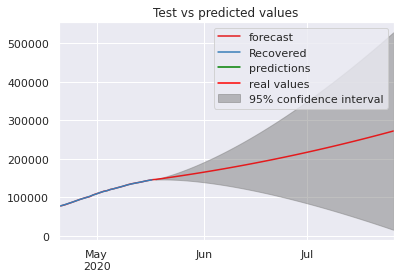

In [23]:

##Mean absolute percentage error
def mape(x1, x_pred): 
    x1, x_pred = np.array(x1), np.array(x_pred)
    return np.mean(np.abs((x1 - x_pred) / x1)) * 100

def split(CDR):
    #splitting 85%/15% because of little amount of data
    size = int(len(CDR) * 0.95)
    train= CDR[:size]
    test = CDR[size:]
    return(train,test)


#Arima modeling for CDR
def arima(CDR,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(CDR, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(CDR, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(CDR) * 0.6), end=int(len(CDR) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    #f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(Sptest)
prediction=arima(train,test)

**For Recovered Cases Brazil**

Predicted values : [111410.88829763]
                             ARIMA Model Results                              
Dep. Variable:           D2.Recovered   No. Observations:                   47
Model:                 ARIMA(0, 2, 0)   Log Likelihood                -368.537
Method:                           css   S.D. of innovations            615.401
Date:                Sun, 27 Sep 2020   AIC                            741.074
Time:                        20:47:35   BIC                            744.774
Sample:                    04-04-2020   HQIC                           742.466
                         - 05-20-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        143.6383     89.766      1.600      0.116     -32.299     319.575
Error Values
Mean Value : Recovered    112474.0
dtype: float64
MAE Value : [1063.11170237]
RMS

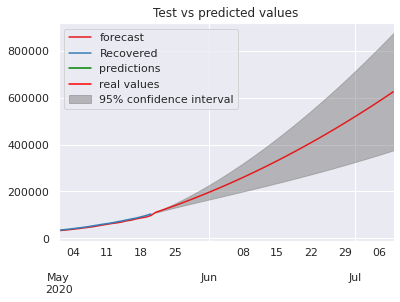

In [24]:

#Mean absolute percentage error
def mape(x1, x_pred): 
    x1, x_pred = np.array(x1), np.array(x_pred)
    return np.mean(np.abs((x1 - x_pred) / x1)) * 100

def split(CDR):
    #splitting 85%/15% because of little amount of data
    size = int(len(CDR) * 0.99)
    train= CDR[:size]
    test = CDR[size:]
    return(train,test)


#Arima modeling for CDR
def arima(CDR,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(CDR, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(CDR, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(CDR) * 0.6), end=int(len(CDR) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    #f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(Bztest)
prediction=arima(train,test)

**For Recovered Cases For Belgium**

Predicted values : [14553.08505679 14707.32869734 14842.16510445 14974.50021109]
                             ARIMA Model Results                              
Dep. Variable:           D2.Recovered   No. Observations:                   55
Model:                 ARIMA(2, 2, 5)   Log Likelihood                -257.874
Method:                       css-mle   S.D. of innovations             24.034
Date:                Sun, 27 Sep 2020   AIC                            533.749
Time:                        20:48:09   BIC                            551.815
Sample:                    03-24-2020   HQIC                           540.735
                         - 05-17-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.1990      4.071      0.540      0.592      -5.780      10.178
ar.L1.D2.Recovered     1.2

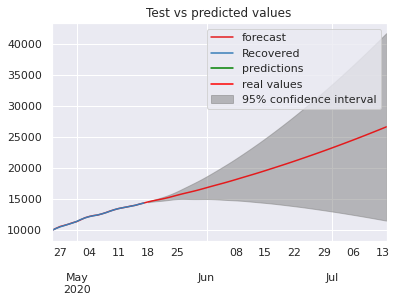

In [25]:
#Mean absolute percentage error
def mape(x1, x_pred): 
    x1, x_pred = np.array(x1), np.array(x_pred)
    return np.mean(np.abs((x1 - x_pred) / x1)) * 100

def split(CDR):
    #splitting 85%/15% because of little amount of data
    size = int(len(CDR) * 0.94)
    train= CDR[:size]
    test = CDR[size:]
    return(train,test)


#Arima modeling for CDR
def arima(CDR,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(CDR, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(CDR, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(CDR) * 0.6), end=int(len(CDR) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    #f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(Bltest)
prediction=arima(train,test)

**Recovered Cases for Iran**

Predicted values : [92391.88690188 93602.5975435  94782.70185402 95962.75129486
 97154.17055767]
                             ARIMA Model Results                              
Dep. Variable:           D2.Recovered   No. Observations:                   76
Model:                 ARIMA(4, 2, 1)   Log Likelihood                -509.064
Method:                       css-mle   S.D. of innovations                nan
Date:                Sun, 27 Sep 2020   AIC                           1032.127
Time:                        20:48:35   BIC                           1048.442
Sample:                    03-02-2020   HQIC                          1038.648
                         - 05-16-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -5.1501     35.939     -0.143      0.886     -75.589      65.289
ar.L1.D2.R

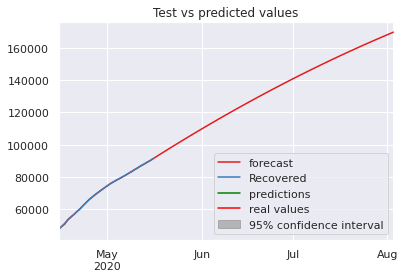

In [26]:
#Mean absolute percentage error
def mape(x1, x_pred): 
    x1, x_pred = np.array(x1), np.array(x_pred)
    return np.mean(np.abs((x1 - x_pred) / x1)) * 100

def split(CDR):
    #splitting 85%/15% because of little amount of data
    size = int(len(CDR) * 0.94)
    train= CDR[:size]
    test = CDR[size:]
    return(train,test)


#Arima modeling for CDR
def arima(CDR,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(CDR, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(CDR, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(CDR) * 0.6), end=int(len(CDR) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    #f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(Irtest)
prediction=arima(train,test)

**Recovered Cases in Mexico**

Predicted values : [34482.38809603 36346.43377258 38250.8939038 ]
                             ARIMA Model Results                              
Dep. Variable:           D2.Recovered   No. Observations:                   45
Model:                 ARIMA(0, 2, 4)   Log Likelihood                -311.758
Method:                       css-mle   S.D. of innovations            220.878
Date:                Sun, 27 Sep 2020   AIC                            635.517
Time:                        20:48:54   BIC                            646.357
Sample:                    04-04-2020   HQIC                           639.558
                         - 05-18-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 40.4145      8.533      4.736      0.000      23.689      57.140
ma.L1.D2.Recovered    -0.0988      0.105 

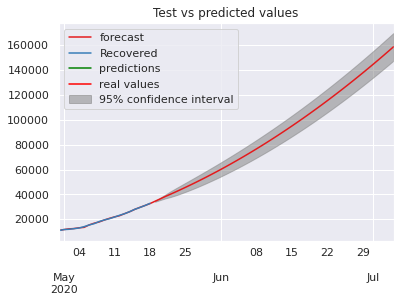

In [27]:
#Mean absolute percentage error
def mape(x1, x_pred): 
    x1, x_pred = np.array(x1), np.array(x_pred)
    return np.mean(np.abs((x1 - x_pred) / x1)) * 100

def split(CDR):
    #splitting 85%/15% because of little amount of data
    size = int(len(CDR) * 0.94)
    train= CDR[:size]
    test = CDR[size:]
    return(train,test)


#Arima modeling for CDR
def arima(CDR,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(CDR, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(CDR, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(CDR) * 0.6), end=int(len(CDR) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    #f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(Mxtest)
prediction=arima(train,test)

**Checking for similarity(Trend) between Germany and Italy in Death cases using number of predicted values from model result.**

In [ ]:

from scipy.special import rel_entr
# defining distributions
Germany = [7972.36959755, 8062.7594309,  8134.85335376, 8202.57606246, 8274.24853297, 8368.85306069]
Italy = [31473.31708024, 31824.28657176, 32179.43901308, 32538.77440418,
 32902.29274508, 33269.99403576]
# calculating (Germany || Italy)
kl_Germany_Italy = rel_entr(Germany, Italy)
print('KL(Germany || Italy): %.3f nats' % sum(kl_Germany_Italy))
# calculating (Italy || Germany)
kl_Italy_Germany = rel_entr(Italy,Germany)
print('KL(Italy || Germany): %.3f nats' % sum(kl_Italy_Germany))

KL(Germany || Italy): -67479.016 nats
KL(Italy || Germany): 267337.231 nats


**Hence,Kl divergence satisfies the condition that KL(Germany || Italy)!=KL(Italy || Germany)**.

In [ ]:

from scipy.spatial.distance import jensenshannon
from numpy import asarray
# defining distributions
Germany = asarray([7972.36959755, 8062.7594309,  8134.85335376, 8202.57606246, 8274.24853297, 8368.85306069])
Italy = asarray([31473.31708024, 31824.28657176, 32179.43901308, 32538.77440418,
 32902.29274508, 33269.99403576])
# calculating (Germany || Italy)
JS_Germany_Italy = jensenshannon(Germany, Italy,base=2)
print('JS(Germany || Italy): %.3f nats' % JS_Germany_Italy)
# calculating (Italy || Germany)
JS_Italy_Germany = jensenshannon(Italy,Germany,base=2)
print('JS(Italy || Germany): %.3f nats' % JS_Italy_Germany)

JS(Germany || Italy): 0.001 nats
JS(Italy || Germany): 0.001 nats


**Hence,JS divergence satisfies the condition that JS(Germany || Italy)==JS(Italy || Germany).**

In [ ]:
from scipy import stats
stats.spearmanr([7972.36959755, 8062.7594309,  8134.85335376, 8202.57606246, 8274.24853297, 8368.85306069], [31473.31708024, 31824.28657176, 32179.43901308, 32538.77440418,
 32902.29274508, 33269.99403576])

np.random.seed(7972)
x2n = np.random.randn(100, 2)
y2n = np.random.randn(100, 2)
stats.spearmanr(x2n)

SpearmanrResult(correlation=0.1438943894389439, pvalue=0.15320623761722527)

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#df = pd.read_csv('synchrony_sample.csv')
overall_pearson_r = dataframe.corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r}")
# out: Pandas computed Pearson r: 0.2058774513561943
#df.loc[(df['Country/Region']==country)]
r, p = stats.pearsonr(dataframe.loc[(Country['Germany'])].dropna(), dataframe.loc[(dataframe['Country(Italy)'])].dropna())
#r, p = stats.pearsonr(df.dropna()['Confirmed'], df.dropna()['Recovered'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")
# out: Scipy computed Pearson r: 0.20587745135619354 and p-value: 3.7902989479463397e-51

# Compute rolling window synchrony
f,ax=plt.subplots(figsize=(7,3))
dataframe.rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}");

Pandas computed Pearson r: -0.1282098089914872


NameError: ignored